# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import json
import plotly.graph_objects as go  # Ensure graph_objects is imported
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point, Polygon
from datetime import datetime
from matplotlib.colors import LogNorm 
import itertools
import pickle

# Working on LODES dataset

In [2]:
df_2020=pd.read_csv("/home/kamal/Desktop/IEEEBigData/Dataset/tn_od_main_JT00_2020.csv")

In [3]:
# Removing the last four digits from 'w_geocode' and 'h_geocode'
df_2020['w_geocode'] = (df_2020['w_geocode'] // 10000)
df_2020['h_geocode'] = (df_2020['h_geocode'] // 10000)

# Removing the 'createdate' column
df_2020.drop(columns=['createdate'], inplace=True)

In [4]:
# Grouping by 'w_geocode' and 'h_geocode' and summing other columns
df_grouped = df_2020.groupby(['w_geocode', 'h_geocode']).sum().reset_index()

In [5]:
# Calculate the percentage of each category based on the 'S000' total
results = {
    'SA01': (df_grouped['SA01'].sum() / df_grouped['S000'].sum()) * 100,
    'SA02': (df_grouped['SA02'].sum() / df_grouped['S000'].sum()) * 100,
    'SA03': (df_grouped['SA03'].sum() / df_grouped['S000'].sum()) * 100,
    'SE01': (df_grouped['SE01'].sum() / df_grouped['S000'].sum()) * 100,
    'SE02': (df_grouped['SE02'].sum() / df_grouped['S000'].sum()) * 100,
    'SE03': (df_grouped['SE03'].sum() / df_grouped['S000'].sum()) * 100,
    'SI01': (df_grouped['SI01'].sum() / df_grouped['S000'].sum()) * 100,
    'SI02': (df_grouped['SI02'].sum() / df_grouped['S000'].sum()) * 100,
    'SI03': (df_grouped['SI03'].sum() / df_grouped['S000'].sum()) * 100
}

In [6]:
df_OD_pairs= df_grouped[['w_geocode','h_geocode']]
# Rename columns to match the names used in your plotting code
df_OD_pairs.rename(columns={
    'w_geocode': 'start(work)',
    'h_geocode': 'end(home)'
}, inplace=True)

/tmp/ipykernel_25185/3685266982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_OD_pairs.rename(columns={


In [7]:
tracts = gpd.read_file('/home/kamal/Desktop/IEEEBigData/Dataset/GeoMap/tl_2020_47_tract.shp')

In [8]:
# Convert 'GEOID' to string
tracts['GEOID'] = tracts['GEOID'].astype(int)
details_tracts = tracts[['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'geometry']]

In [9]:
# Assuming 'tracts' is your GeoDataFrame
details_tracts.loc[:, 'centroid'] = details_tracts['geometry'].centroid

# Extracting latitude and longitude from the centroid
details_tracts.loc[:, 'centroid_lat'] = details_tracts['centroid'].y
details_tracts.loc[:, 'centroid_lon'] = details_tracts['centroid'].x

tracts_centroid= details_tracts[['GEOID', 'centroid_lat', 'centroid_lon']]

/tmp/ipykernel_25185/2821047908.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  details_tracts.loc[:, 'centroid'] = details_tracts['geometry'].centroid
/home/kamal/Desktop/IEEEBigData/venvBigData/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/kamal/Desktop/IEEEBigData/venvBigData/lib/python3.12/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

In [10]:
 # Assuming df_OD_pairs and tracts_centroid are already defined
tracts_centroid_new = tracts_centroid.copy()


# Rename columns for merging
tracts_centroid_new = tracts_centroid_new.rename(columns={'centroid_lat': 'start_lat', 'centroid_lon': 'start_lon'})

# Merge for start locations
df_OD_pairs = df_OD_pairs.merge(tracts_centroid_new, how='left', left_on='start(work)', right_on='GEOID')

# Rename columns for end locations
tracts_centroid_new = tracts_centroid_new.rename(columns={'start_lat': 'end_lat', 'start_lon': 'end_lon', 'GEOID': 'end(home)'})

# Merge for end locations
df_OD_pairs = df_OD_pairs.merge(tracts_centroid_new, how='left', on='end(home)')

# Drop the extra columns if needed (optional)
df_OD_pairs.drop(columns=['GEOID'], inplace=True, errors='ignore')


# Working with airport

In [11]:
df_airports = pd.read_csv('/home/kamal/Desktop/IEEEBigData/Dataset/airports_new.csv')
# Select airports in Tennessee and create a copy to avoid SettingWithCopyWarning
tn_airports = df_airports[df_airports['state'] == 'TN'].copy()

# Rename columns to match the names used in your plotting code
tn_airports.rename(columns={
    'lat': 'LATITUDE',
    'long': 'LONGITUDE',  # Corrected column name with stripped spaces
    'iata': 'IATA'
}, inplace=True)

# Finding nearest airports from the census tracts

In [12]:
df_OD_distance_time=pd.read_csv("/home/kamal/Desktop/IEEEBigData/Dataset/merged_od_distances_times.csv")

In [13]:
# Group by start_lon and start_lat, then find the minimum distance for each group
result_df = df_OD_distance_time.loc[df_OD_distance_time.groupby(['start_lon', 'start_lat'])['distance_miles'].idxmin()]

# Reset the index to get a clean dataframe
result_df = result_df.reset_index(drop=True)

In [14]:
# Assuming tn_airports and result_df are already defined

# Merge result_df with tn_airports to get the IATA codes
final_df = result_df.merge(tn_airports, left_on=['end_lat', 'end_lon'], right_on=['LATITUDE', 'LONGITUDE'], how='left')

# Select relevant columns and rename them accordingly
final_df = final_df[['start_lon', 'start_lat', 'end_lon', 'end_lat', 'distance_miles', 'duration_seconds', 'IATA']]

In [15]:
# Assuming tracts_centroid and final_df are already defined

# Ensure GEOID in tracts_centroid is treated as a string
tracts_centroid['GEOID'] = tracts_centroid['GEOID'].astype(str)

# Round start_lat, start_lon, centroid_lat, and centroid_lon to six decimal places
final_df['start_lat'] = final_df['start_lat'].round(6)
final_df['start_lon'] = final_df['start_lon'].round(6)
tracts_centroid['centroid_lat'] = tracts_centroid['centroid_lat'].round(6)
tracts_centroid['centroid_lon'] = tracts_centroid['centroid_lon'].round(6)

# Merge final_df with tracts_centroid to get the GEOID
final_df = final_df.merge(tracts_centroid, left_on=['start_lat', 'start_lon'], right_on=['centroid_lat', 'centroid_lon'], how='left')

# Select relevant columns and rename them accordingly
final_df = final_df[['start_lon', 'start_lat', 'end_lon', 'end_lat', 'distance_miles', 'duration_seconds', 'IATA', 'GEOID']]

/tmp/ipykernel_25185/2552379548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracts_centroid['GEOID'] = tracts_centroid['GEOID'].astype(str)
/tmp/ipykernel_25185/2552379548.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracts_centroid['centroid_lat'] = tracts_centroid['centroid_lat'].round(6)
/tmp/ipykernel_25185/2552379548.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

# Finding inter-airport distances

In [16]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    R = 3959.0  # Earth radius in miles

    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    distance = R * c
    return distance


# # Generate all possible origin-destination pairs (including both directions)
# pairs = list(itertools.permutations(tn_airports.index, 2))

# Generate all possible origin-destination pairs (including same index pairs)
pairs = list(itertools.product(tn_airports.index, repeat=2))

# Calculate Haversine distances for each pair
distances = []
for (i, j) in pairs:
    lat1, lon1 = tn_airports.loc[i, ['LATITUDE', 'LONGITUDE']]
    lat2, lon2 = tn_airports.loc[j, ['LATITUDE', 'LONGITUDE']]
    distance = haversine(lat1, lon1, lat2, lon2)
    distances.append((tn_airports.loc[i, 'IATA'], tn_airports.loc[j, 'IATA'], distance))

# Create a new dataframe for origin-destination pairs with distances
df_distances = pd.DataFrame(distances, columns=['Origin', 'Destination', 'Distance_H'])

# GCT for ground transportation

In [17]:
df_OD=pd.read_csv("/home/kamal/Desktop/IEEEBigData/Dataset/OD_pairs_results.csv")

In [18]:
# Directly add the columns from df_OD_pairs to df_OD
df_OD['start(work)'] = df_OD_pairs['start(work)']
df_OD['end(home)'] = df_OD_pairs['end(home)']

In [19]:
# Remove the rows where distance_miles is 0.0
df_OD = df_OD[df_OD['distance_miles'] != 0.0]

In [20]:
df_OD['time_hours'] = df_OD['duration_seconds'] / 3600

In [21]:
# Calculating the wages for the overall Tennesse State by averaging over two years 2021 and 2022 for predicting the overall GCT value
# Source: https://www.bls.gov/oes/tables.htm

TN_Wages_2021_Median= 18.13
TN_Wages_2021_Mean= 	23.72
TN_Wages_2022_Median= 19.20
TN_Wages_2022_Mean= 25.39


TN_Wages_Median= (TN_Wages_2021_Median + TN_Wages_2022_Median)/2
TN_Wages_Mean= (TN_Wages_2021_Mean + TN_Wages_2022_Mean)/2

# Mileage rates (cents/mile)
# Source : https://www.irs.gov/tax-professionals/standard-mileage-rates

Business_2021= 56
Charity_2021 = 14
MedicalOrMilitary_2021= 16


Business_2022= (62.5 + 58.5)/2
Charity_2022 = (14 + 14)/2
MedicalOrMilitary_2022= (22 + 18)/2


# Calculating average for two years:
Business_mean= (Business_2021 + Business_2022)/2
Charity_mean = (Charity_2021 + Charity_2022)/2
MedicalOrMilitary_mean= (MedicalOrMilitary_2021 + MedicalOrMilitary_2022)/2

# Data related to the VSL
mean_VSL=12.15
mean_fatal_accident_rate_ground=1.592798223e-08
mean_fatal_accident_rate_air=5e-11

In [22]:
df_OD_pairs= df_OD.copy()
df_OD_pairs.loc[:,'GCT_G'] = (df_OD_pairs['distance_miles'] * Business_mean)/100  + TN_Wages_Median * df_OD_pairs['time_hours'] + df_OD_pairs['distance_miles'] * mean_VSL * mean_fatal_accident_rate_ground # Wages are not from MSAs, can be improved.

# GCT RAM

In [23]:
# Lets calculate the first and last part GCT which is equivalent to the ground transportation between the airports

In [24]:
final_df['time_hours'] = final_df['duration_seconds'] / 3600

final_df.loc[:,'GCT_G'] = (final_df['distance_miles'] * Business_mean)/100  + TN_Wages_Median * final_df['time_hours'] + final_df['distance_miles'] * mean_VSL * mean_fatal_accident_rate_ground # Wages are not from MSAs, can be improved.

In [25]:
columns_to_copy = ['distance_miles', 'IATA', 'GEOID' , 'time_hours' , 'GCT_G']

# Create a new DataFrame with only the specified columns
df_RAM_GCT_Ground = final_df[columns_to_copy].copy()

In [26]:
# Second step is to find the GCT related to the air transportation phase in the RAM

# Load coefficients from the file
with open('/home/kamal/Desktop/IEEEBigData/SavedModel/polynomial_cost_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df_distances['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_cost = np.polyval(loaded_coefficients, distances)

df_distances=df_distances.copy()

# Add the predicted cost column to the original DataFrame
df_distances.loc[:, 'Cost_Airlines'] = predicted_cost * df_distances['Distance_H']

In [27]:
# Load coefficients from the file
with open('/home/kamal/Desktop/IEEEBigData/SavedModel/polynomial_blockTime_coefficients.pkl', 'rb') as file:
    loaded_coefficients = pickle.load(file)



distances = df_distances['Distance_H'].values  # Read the distance values from the 'distance' column

# Assuming 'loaded_coefficients' contains the polynomial coefficients for prediction
predicted_blockTime = np.polyval(loaded_coefficients, distances)

df_distances=df_distances.copy()

# Add the predicted cost column to the original DataFrame
df_distances.loc[:, 'Time_Airlines'] = predicted_blockTime

df_distances.loc[df_distances['Distance_H'] == 0, ['Time_Airlines']] = 0

In [28]:
df_distances.loc[:,'GCT_A'] = df_distances['Cost_Airlines']  + TN_Wages_Median * df_distances['Time_Airlines'] + df_distances['Distance_H'] * mean_VSL * mean_fatal_accident_rate_air  # Wages are not from MSAs, can be improved.

In [29]:
df_GCT_RAM = df_OD_pairs[['start(work)','end(home)', 'distance_miles', 'time_hours', 'GCT_G']]

In [30]:
# Convert columns to string type
df_GCT_RAM['start(work)'] = df_GCT_RAM['start(work)'].astype(str)
df_GCT_RAM['end(home)'] = df_GCT_RAM['end(home)'].astype(str)
final_df['GEOID'] = final_df['GEOID'].astype(str)

# Merging df_GCT_RAM with final_df to get the start(IATA)
df_merged_start = df_GCT_RAM.merge(final_df, left_on='start(work)', right_on='GEOID', how='left')
df_merged_start = df_merged_start.rename(columns={'IATA': 'start(IATA)'}).drop(columns=['GEOID'])

# Merging the result with final_df again to get the end(IATA)
df_merged_final = df_merged_start.merge(final_df, left_on='end(home)', right_on='GEOID', how='left')
df_merged_final = df_merged_final.rename(columns={'IATA': 'end(IATA)'}).drop(columns=['GEOID'])

# Selecting the required columns
result_df = df_merged_final[['start(work)', 'end(home)', 'start(IATA)', 'end(IATA)']]

/tmp/ipykernel_25185/3685213814.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM['start(work)'] = df_GCT_RAM['start(work)'].astype(str)
/tmp/ipykernel_25185/3685213814.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM['end(home)'] = df_GCT_RAM['end(home)'].astype(str)


In [31]:
# Convert relevant columns to string type
df_GCT_RAM['start(work)'] = df_GCT_RAM['start(work)'].astype(str)
df_GCT_RAM['end(home)'] = df_GCT_RAM['end(home)'].astype(str)
final_df['GEOID'] = final_df['GEOID'].astype(str)
df_RAM_GCT_Ground['GEOID'] = df_RAM_GCT_Ground['GEOID'].astype(str)

# Merging df_GCT_RAM with final_df to get the start(IATA)
df_merged_start = df_GCT_RAM.merge(final_df, left_on='start(work)', right_on='GEOID', how='left')
df_merged_start = df_merged_start.rename(columns={'IATA': 'start(IATA)'}).drop(columns=['GEOID'])

# Merging the result with final_df again to get the end(IATA)
df_merged_final = df_merged_start.merge(final_df, left_on='end(home)', right_on='GEOID', how='left')
df_merged_final = df_merged_final.rename(columns={'IATA': 'end(IATA)'}).drop(columns=['GEOID'])

# Selecting the required columns
result_df = df_merged_final[['start(work)', 'end(home)', 'start(IATA)', 'end(IATA)']]

# Adding GCT_start column
result_df = result_df.merge(df_RAM_GCT_Ground[['GEOID', 'IATA', 'GCT_G', 'time_hours', 'distance_miles']],
                            left_on=['start(work)', 'start(IATA)'],
                            right_on=['GEOID', 'IATA'],
                            how='left').rename(columns={'GCT_G': 'GCT_start','time_hours':'time_hours_start', 'distance_miles': 'distance_miles_start'}).drop(columns=['GEOID', 'IATA'])

# Adding GCT_end column
result_df = result_df.merge(df_RAM_GCT_Ground[['GEOID', 'IATA', 'GCT_G', 'time_hours', 'distance_miles']],
                            left_on=['end(home)', 'end(IATA)'],
                            right_on=['GEOID', 'IATA'],
                            how='left').rename(columns={'GCT_G': 'GCT_end','time_hours':'time_hours_end', 'distance_miles': 'distance_miles_end'}).drop(columns=['GEOID', 'IATA'])

/tmp/ipykernel_25185/16293076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM['start(work)'] = df_GCT_RAM['start(work)'].astype(str)
/tmp/ipykernel_25185/16293076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM['end(home)'] = df_GCT_RAM['end(home)'].astype(str)


In [32]:
# Merge the dataframes
merged_df = pd.merge(result_df, df_distances, left_on=['start(IATA)', 'end(IATA)'], right_on=['Origin', 'Destination'], how='left')

In [33]:
merged_df['GCT_RAM'] = merged_df['GCT_start'] + merged_df['GCT_end'] + merged_df['GCT_A']
merged_df['GCT_G(RAM)'] = merged_df['GCT_start'] + merged_df['GCT_end']
merged_df['Time_G(RAM)'] = merged_df['time_hours_start'] + merged_df['time_hours_end']
merged_df['Distance_G(RAM)'] = merged_df['distance_miles_start'] + merged_df['distance_miles_end']
df_GCT_RAM_Final= merged_df[['start(work)', 'end(home)', 'GCT_A', 'GCT_G(RAM)', 'GCT_RAM', 'Time_G(RAM)', 'Distance_G(RAM)', 'Distance_H', 'Time_Airlines']]

In [34]:
df_GCT_Ground_Final = df_OD_pairs[['start(work)', 'end(home)', 'GCT_G', 'distance_miles', 'time_hours']]

In [35]:
# Convert columns to strings in both dataframes
df_GCT_RAM_Final['start(work)'] = df_GCT_RAM_Final['start(work)'].astype(str)
df_GCT_RAM_Final['end(home)'] = df_GCT_RAM_Final['end(home)'].astype(str)
df_GCT_Ground_Final['start(work)'] = df_GCT_Ground_Final['start(work)'].astype(str)
df_GCT_Ground_Final['end(home)'] = df_GCT_Ground_Final['end(home)'].astype(str)

# Merge the dataframes
merged_df = pd.merge(df_GCT_RAM_Final, df_GCT_Ground_Final, left_on=['start(work)', 'end(home)'], right_on=['start(work)', 'end(home)'], how='left')

# # Merge the dataframes
# merged_df = pd.merge(df_GCT_RAM_Final, df_GCT_Ground_Final, left_on=['start(work)', 'end(home)'], right_on=['start(work)', 'end(home)'], how='left')

df_final_result= merged_df.copy()

/tmp/ipykernel_25185/1525034166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM_Final['start(work)'] = df_GCT_RAM_Final['start(work)'].astype(str)
/tmp/ipykernel_25185/1525034166.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_GCT_RAM_Final['end(home)'] = df_GCT_RAM_Final['end(home)'].astype(str)
/tmp/ipykernel_25185/1525034166.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [36]:
# Create a function to determine the lowest GCT value
def find_lowest_gct_between_ground_and_RAM(row):
    min_value = min(row['GCT_G'], row['GCT_RAM'])
    if row['GCT_G'] == min_value:
        return 0
    else:
        return 1

# Apply the function to each row
merged_df['RAM_Trip'] = merged_df.apply(find_lowest_gct_between_ground_and_RAM, axis=1)

In [37]:
# Filter the rows where RAM_Trip is 1 and create a new dataframe df_RAM_OD
df_RAM_OD = merged_df[merged_df['RAM_Trip'] == 1]

In [38]:
# Renaming columns
df_grouped.rename(columns={
    'w_geocode': 'start(work)',
    'h_geocode': 'end(home)'
}, inplace=True)

In [39]:
# Ensure data types are consistent
df_RAM_OD['start(work)'] = df_RAM_OD['start(work)'].astype(str)
df_RAM_OD['end(home)'] = df_RAM_OD['end(home)'].astype(str)
df_grouped['start(work)'] = df_grouped['start(work)'].astype(str)
df_grouped['end(home)'] = df_grouped['end(home)'].astype(str)

# Merging the dataframes on 'start(work)' and 'end(home)'
merged_df = pd.merge(df_RAM_OD, df_grouped, on=['start(work)', 'end(home)'], how='inner')

/tmp/ipykernel_25185/654354450.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RAM_OD['start(work)'] = df_RAM_OD['start(work)'].astype(str)
/tmp/ipykernel_25185/654354450.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_RAM_OD['end(home)'] = df_RAM_OD['end(home)'].astype(str)


In [40]:
# List of columns you want to copy
selected_columns = ['start(work)', 'end(home)', 'S000']

# Creating a new dataframe with only the selected columns
df_final_OD_RAM = merged_df[selected_columns].copy()


# Renaming columns
df_final_OD_RAM.rename(columns={
    'start(work)': 'Work',
    'end(home)': 'Home',
    'S000': 'Trip'
}, inplace=True)

In [41]:
df_final_OD_RAM['Trip'] = df_final_OD_RAM['Trip'] *2

In [42]:
# Calculate the percentage of each category based on the 'S000' total
results = {
    'SA01': (merged_df['SA01'].sum() / merged_df['S000'].sum()) * 100,
    'SA02': (merged_df['SA02'].sum() / merged_df['S000'].sum()) * 100,
    'SA03': (merged_df['SA03'].sum() / merged_df['S000'].sum()) * 100,
    'SE01': (merged_df['SE01'].sum() / merged_df['S000'].sum()) * 100,
    'SE02': (merged_df['SE02'].sum() / merged_df['S000'].sum()) * 100,
    'SE03': (merged_df['SE03'].sum() / merged_df['S000'].sum()) * 100,
    'SI01': (merged_df['SI01'].sum() / merged_df['S000'].sum()) * 100,
    'SI02': (merged_df['SI02'].sum() / merged_df['S000'].sum()) * 100,
    'SI03': (merged_df['SI03'].sum() / merged_df['S000'].sum()) * 100
}

# Visualization of result

In [43]:
df_final_result = df_final_result[df_final_result['Distance_H'] != 0]
df_final_result = df_final_result[df_final_result['distance_miles'] >= 10]

In [44]:
# Calculate the percentage of Cost_RAM_A in the Total_Trip_Cost and assign it to a new column
df_final_result['Percentage'] = (df_final_result['GCT_A'] / df_final_result['GCT_RAM'])

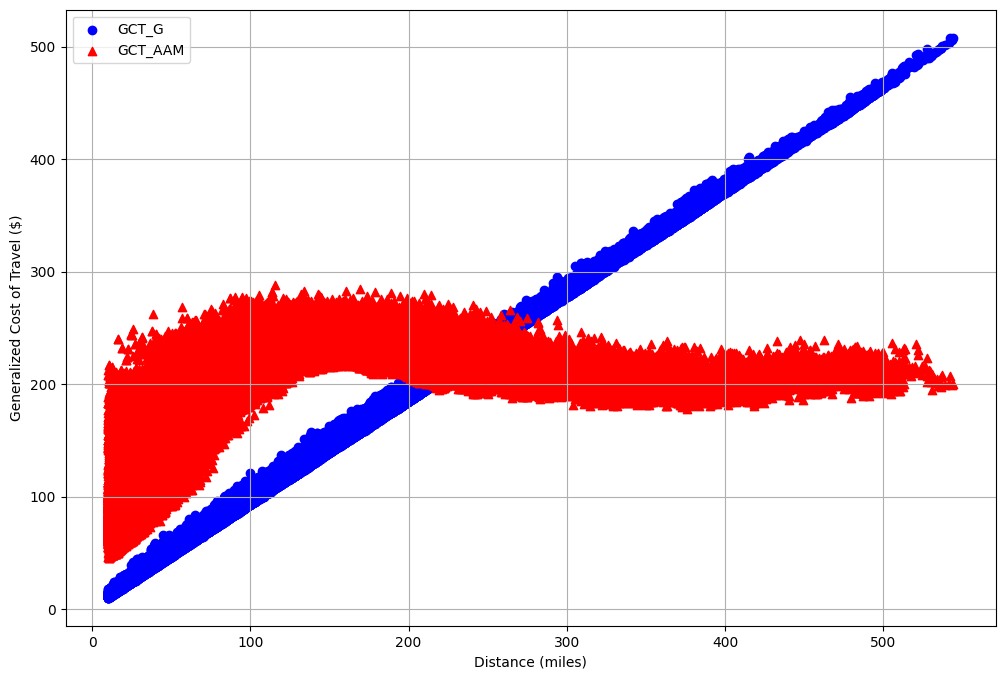

In [45]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df_final_result['distance_miles'], df_final_result['GCT_G'], label='GCT_G', color='blue', marker='o')
# Scatter plot for GCT_RAM
plt.scatter(df_final_result['distance_miles'], df_final_result['GCT_RAM'], label='GCT_AAM', color='red', marker='^')

# Annotate some outliers
outliers = df_final_result[ (df_final_result['GCT_RAM'] > 350)]
for i, row in outliers.iterrows():
    plt.annotate(f"{row['Origin']}-{row['Destination']}",
                 (row['Distance_G'], row['GCT_RAM']),
                 textcoords="offset points", xytext=(0,10), ha='center')

# Titles and labels
# plt.title('GCT vs Distance for Ground, Air, and RAM')
plt.xlabel('Distance (miles)')
plt.ylabel('Generalized Cost of Travel ($)')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [46]:
scaler = MinMaxScaler()

# Concatenate GCT columns for unified scaling
gct_values = pd.concat([df_final_result['GCT_G'], df_final_result['GCT_RAM']])
gct_scaled = scaler.fit_transform(gct_values.values.reshape(-1, 1)).flatten()

# Split the scaled values back into the original columns
df_final_result['GCT_G'], df_final_result['GCT_RAM'] = gct_scaled[:len(df_final_result)], gct_scaled[len(df_final_result):]

df_new = df_final_result.copy()

# Calculate the P_RAM column
df_new['P_RAM'] = 1 / (1 + np.exp(df_new['GCT_RAM'] - df_new['GCT_G'])) # due to negative sign we swap the place

In [47]:
# Calculate the P_RAM column
df_new['P_G'] = 1 / (1 + np.exp(df_new['GCT_G'] - df_new['GCT_RAM']))

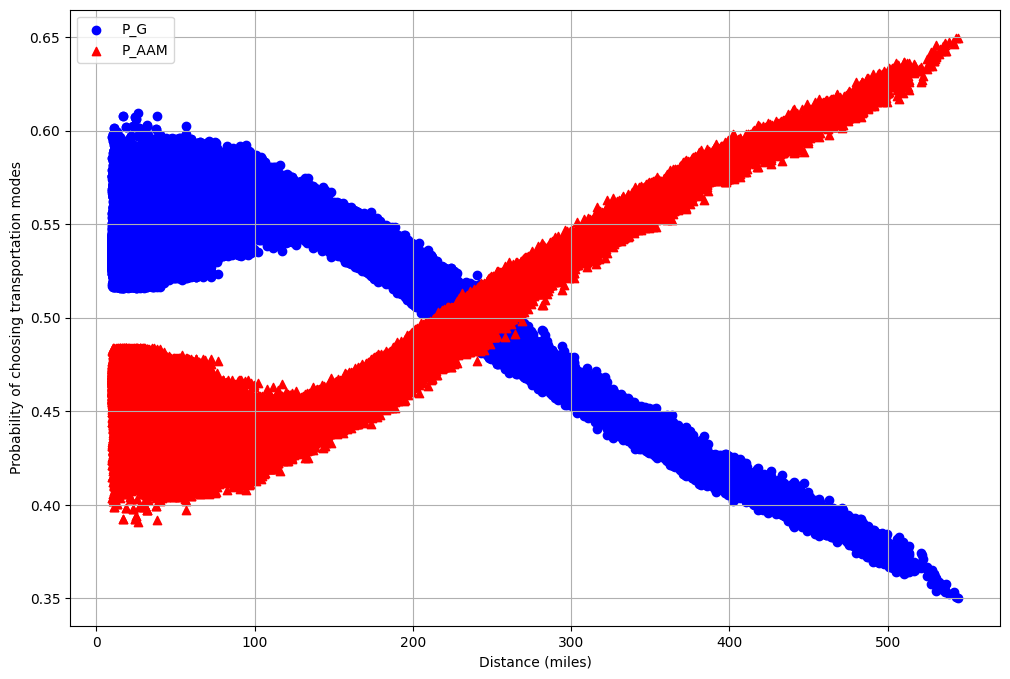

In [48]:
# Plot settings
plt.figure(figsize=(12, 8))

# Scatter plot for GCT_G
plt.scatter(df_new['distance_miles'], df_new['P_G'], label='P_G', color='blue', marker='o')
# Scatter plot for GCT_RAM
plt.scatter(df_new['distance_miles'], df_new['P_RAM'], label='P_AAM', color='red', marker='^')
plt.xlabel('Distance (miles)')
plt.ylabel('Probability of choosing transportation modes')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

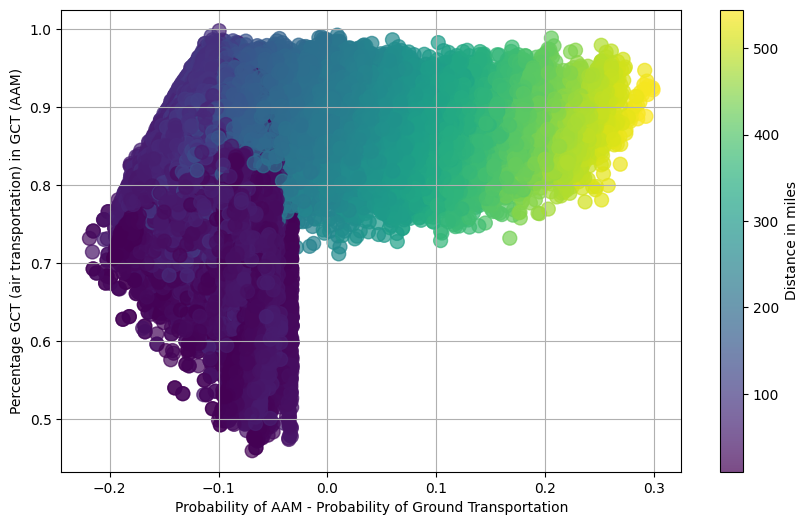

In [49]:
# Calculate GCT_G - GCT_RAM
df_new['P_Difference'] = df_new['P_RAM'] - df_new['P_G']


# Plotting
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df_new['P_Difference'], df_new['Percentage'], c=df_new['distance_miles'], cmap='viridis', s=100, alpha=0.7)
plt.xlabel('Probability of AAM - Probability of Ground Transportation')
plt.ylabel('Percentage GCT (air transportation) in GCT (AAM)')
# plt.title('Plot of GCT_G - GCT_AAM against Percentage with Distance_G')
plt.colorbar(scatter, label='Distance in miles')
plt.grid(True)
plt.show()

# Percentage above around 80 and distance above around 250 miles in case of Tennessee state

In [50]:
# Create a function to determine the lowest GCT value
def find_lowest_gct_between_ground_and_RAM(row):
    min_value = min(row['GCT_G'], row['GCT_RAM'])
    if row['GCT_G'] == min_value:
        return 0
    else:
        return 1

# Apply the function to each row
df_final_result['RAM_Trip'] = df_final_result.apply(find_lowest_gct_between_ground_and_RAM, axis=1)

# Plotting ODs n Map of Tennessee

In [51]:
tracts = gpd.read_file('/home/kamal/Desktop/IEEEBigData/Dataset/GeoMap/tl_2020_47_tract.shp')

In [52]:
# Filter the data based on RAM_Trip
df_RAM_Trip_0 = df_final_result[df_final_result['RAM_Trip'] == 0]
df_RAM_Trip_1 = df_final_result[df_final_result['RAM_Trip'] == 1]

In [53]:
# Get counts of each GEOID in 'start(work)' and 'end(home)'
start_counts = df_RAM_Trip_1['start(work)'].value_counts()
end_counts = df_RAM_Trip_1['end(home)'].value_counts()

# Combine the counts
GEOID_counts = start_counts.add(end_counts, fill_value=0).astype(int)  # Use fill_value=0 to handle missing keys in either series

# Convert to dictionary
GEOID_dict = GEOID_counts.to_dict()

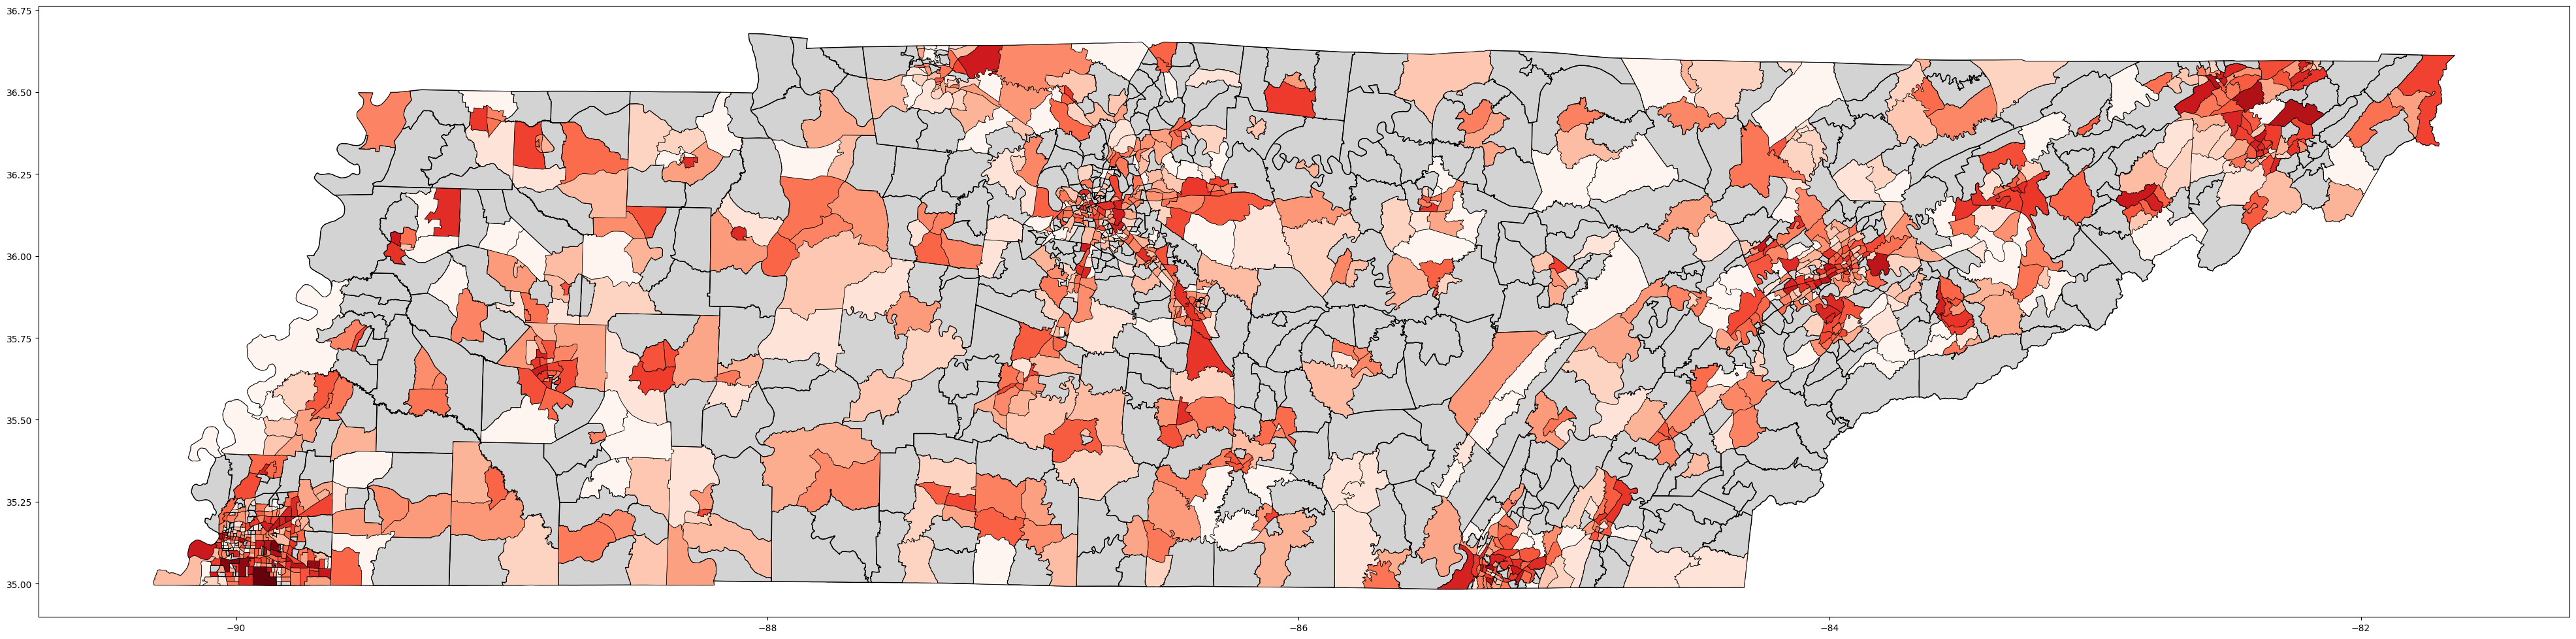

In [54]:
# Combine the counts
GEOID_counts= df_RAM_Trip_1['start(work)'].value_counts()

# Ensure GEOID format matches that in the shapefile, e.g., adding leading zeros
tracts['GEOID'] = tracts['GEOID'].astype(str)
GEOID_counts.index = GEOID_counts.index.astype(str)

# Create a new column in tracts DataFrame for counts
tracts['count'] = tracts['GEOID'].map(GEOID_counts).fillna(0)

# Normalize the counts for coloring
norm = LogNorm(vmin=tracts['count'].min() + 1, vmax=tracts['count'].max())  # Adding 1 to avoid log(0)
cmap = plt.get_cmap('Reds')  # Changing colormap to viridis for better visual differentiation

# Plot the map of Tennessee with the target census tracts highlighted
fig, ax = plt.subplots(figsize=(50, 200))  # Adjust figsize to your needs
tracts.plot(ax=ax, color='lightgrey', edgecolor='black')  # Base map in light grey for better contrast

# Plotting tracts with counts
tracts.plot(ax=ax, column='count', cmap=cmap, norm=norm, edgecolor='black', linewidth=0.5)

# Adding title and legend
# cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
# cbar.set_label('Frequency of GEOIDs')
# ax.set_title('Census Tracts for Job part of OD pairs in Tennessee')
plt.show()

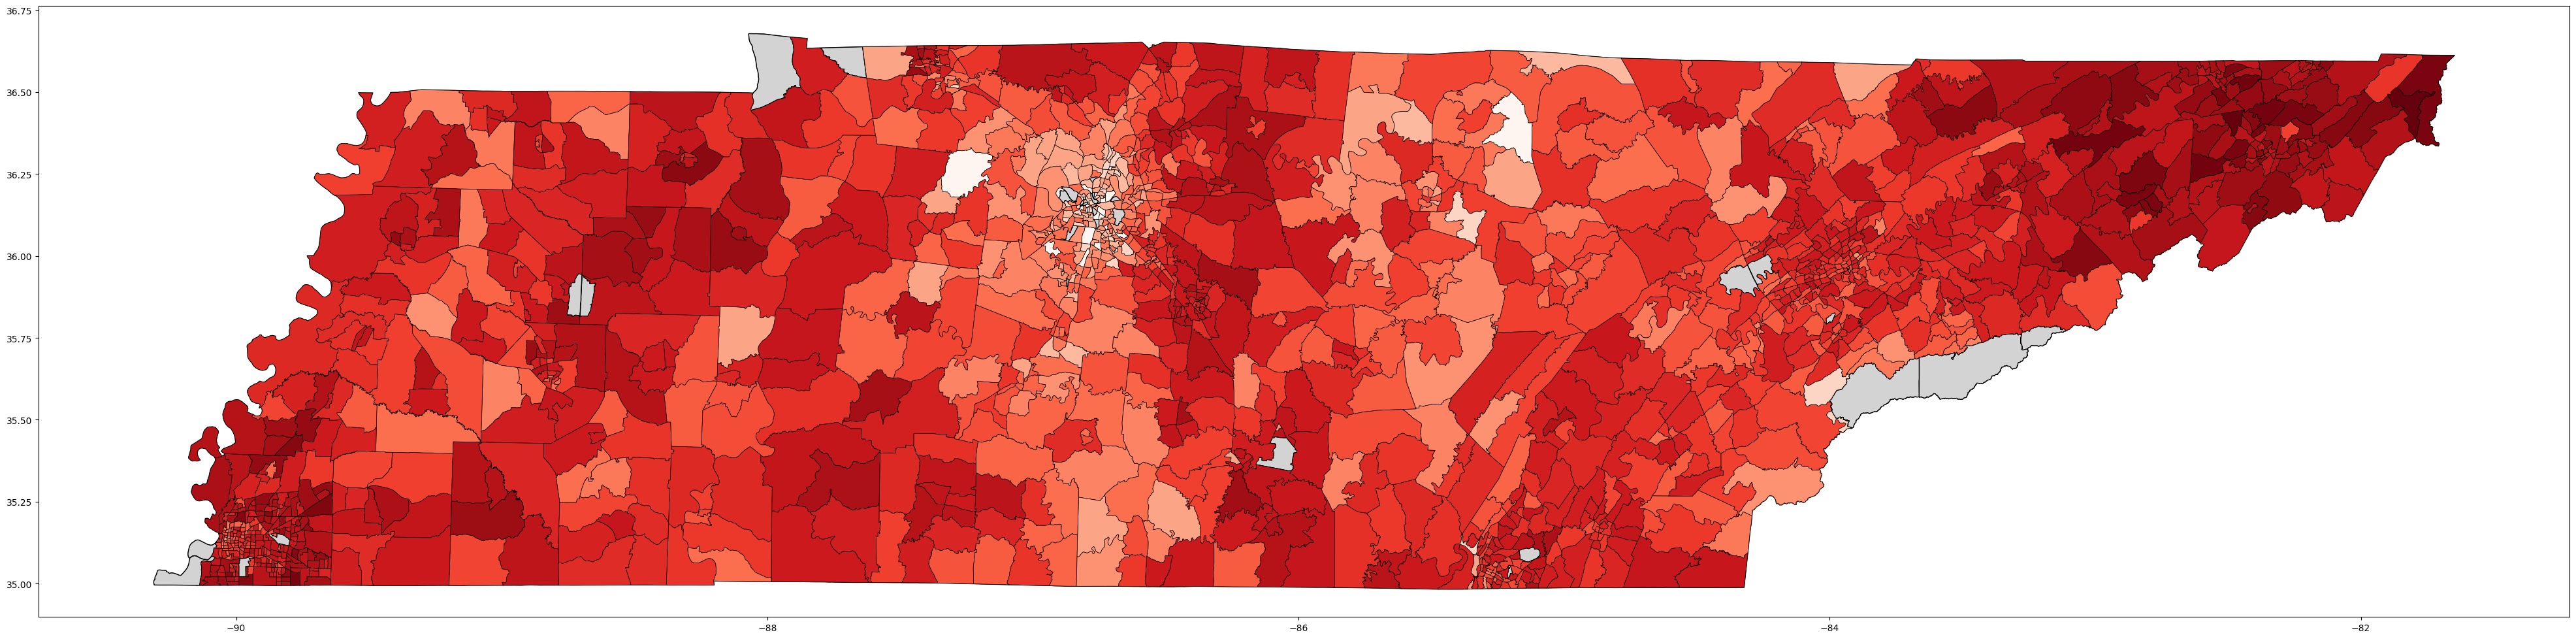

In [55]:
# Combine the counts
GEOID_counts= df_RAM_Trip_1['end(home)'].value_counts()

# Ensure GEOID format matches that in the shapefile, e.g., adding leading zeros
tracts['GEOID'] = tracts['GEOID'].astype(str)
GEOID_counts.index = GEOID_counts.index.astype(str)

# Create a new column in tracts DataFrame for counts
tracts['count'] = tracts['GEOID'].map(GEOID_counts).fillna(0)

# Normalize the counts for coloring
norm = LogNorm(vmin=tracts['count'].min() + 1, vmax=tracts['count'].max())  # Adding 1 to avoid log(0)
cmap = plt.get_cmap('Reds')  # Changing colormap to viridis for better visual differentiation

# Plot the map of Tennessee with the target census tracts highlighted
fig, ax = plt.subplots(figsize=(50, 200))  # Adjust figsize to your needs
tracts.plot(ax=ax, color='lightgrey', edgecolor='black')  # Base map in light grey for better contrast

# Plotting tracts with counts
tracts.plot(ax=ax, column='count', cmap=cmap, norm=norm, edgecolor='black', linewidth=0.5)

# Adding title and legend
# cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
# cbar.set_label('Frequency of GEOIDs')
# ax.set_title('Census Tracts for Home part of OD pairs in Tennessee')
plt.show()